# Spatial Interaction using Multiple Modes

Instead of the public transport / vehicle thing, use all 4 measures

In [1]:
# load libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import osmnx as ox

# load helper functions
from spatial_interaction_tools import *

## Run the model

In [2]:
# load the data

# od data from scenarios 
od_matrix = pd.read_pickle(os.path.join('data', 'tokyo', 'pt_network_time_scenarios_updated.pkl'))

# load distance for POIs
distance_poi = pd.read_pickle('data/tokyo/travel_time_poi.pkl')

In [3]:
# remove the 'zone_'
for c in ['source', 'target']:
    distance_poi[c] = distance_poi[c].str.replace('zone_', '').astype(int)

# merge
od_matrix_merged = od_matrix.merge(
    distance_poi,
    on = ['source', 'target']
)

In [4]:
# remove internal flows
od_matrix_exc = od_matrix_merged[od_matrix_merged['source'] != od_matrix_merged['target']].copy()

In [5]:
# get list of scenarios
scenarios = [n.replace('driving_time_', '') for n in od_matrix_exc.columns if 'driving_time' in n]

In [6]:
# dictionary of modes that compete
modes = {
    'modes': ['vehicle', 'bus', 'rail', 'walk'],
    'cost': ['drive_time', 'bus_time', 'rail_time', 'ped_time'],
    'path': ['drive_path', 'bus_path', 'rail_path', 'ped_path'],
    'observed_flow': ['vehicle', 'bus', 'rail', 'pedestrian']
}

In [7]:
# run the model
matrix_orig, beta_orig = calibrate_model(
    od_matrix_exc,
    modes = modes,
    thres = 0.01,
    AiBj_init = 0.001,
    show_log = False
)

In [8]:
beta_orig

{'vehicle': 0.20477048494443637,
 'bus': 0.06681694870278414,
 'rail': 0.02701798960144631,
 'walk': 0.09107899090755942}

In [9]:
models_dict = {
    'scenario': [],
    'model': []
}

for s in scenarios:
    # log
    print(f'Calculating scenario: {s}')
    # edit modes
    modes_edit = modes.copy()
    modes_edit['cost'] = [f'driving_time_{s}', 'bus_time', 'rail_time', 'ped_time']
    modes_edit['path'] = [f'driving_path_{s}', 'bus_path', 'rail_path', 'ped_path']

    # run the model
    matrix = calibrate_model(
        od_matrix_exc,
        modes = modes_edit,
        beta_init = beta_orig,
        calib_beta = False,
        thres = 0.01,
        AiBj_init = 0.001,
        show_log = False
    )

    # add to dictionary
    models_dict['scenario'].append(s)
    models_dict['model'].append(matrix)

Calculating scenario: orig
Calculating scenario: removed_Ginza
Calculating scenario: removed_Akihabara
Calculating scenario: removed_Shinjuku
Calculating scenario: removed_Chuo_dori
Calculating scenario: removed_all
Calculating scenario: removed_Ginza_nodes
Calculating scenario: removed_Akihabara_nodes
Calculating scenario: removed_Shinjuku_nodes
Calculating scenario: removed_Chuo_dori_nodes
Calculating scenario: removed_all_nodes
Calculating scenario: 0
Calculating scenario: 10
Calculating scenario: 20
Calculating scenario: 30
Calculating scenario: 40
Calculating scenario: 50
Calculating scenario: 60
Calculating scenario: 70
Calculating scenario: 80
Calculating scenario: 90
Calculating scenario: 100
Calculating scenario: 110
Calculating scenario: 120
Calculating scenario: 130
Calculating scenario: 140
Calculating scenario: 150
Calculating scenario: 160
Calculating scenario: 170
Calculating scenario: 180
Calculating scenario: 190
Calculating scenario: 200
Calculating scenario: 210
Calc

## Analyse the model

In [10]:
# add dict for percentage
for m in modes['modes']:
    models_dict[m] = []

for df in models_dict['model']:
    for m in modes['modes']:
        share = df[f'pred_{m}'].sum() / df['pred_total'].sum()
        models_dict[m].append(share)


In [11]:
models_df = pd.DataFrame(models_dict)

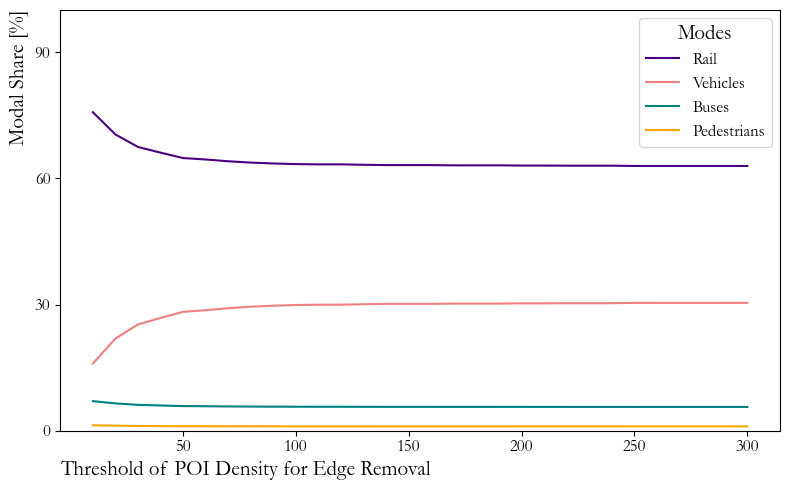

In [17]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Garamond', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']

fig, ax = plt.subplots(1, 1, figsize = (8, 5))

# plot the lines
models_df[['scenario'] + modes['modes']].iloc[12:].plot.line(
    x = 'scenario',
    y = ['rail', 'vehicle', 'bus', 'walk'],
    ax = ax,
    color = ['indigo', 'lightcoral', 'teal', 'orange']
)

plt.legend(
    loc = 'upper right', 
    title = 'Modes',
    labels = ['Rail', 'Vehicles', 'Buses', 'Pedestrians'],
    fontsize = 12,
    title_fontsize = 15
)

ax.set_xticks(range(4,30,5))
ax.set_xticklabels(range(50,320,50), fontsize = 12)
ax.set_ylim([0, 1])
ax.set_yticks(np.arange(0,1,0.3))
ax.set_yticklabels(np.arange(0,100,30), fontsize = 12)

ax.set_xlabel('Threshold of POI Density for Edge Removal', fontsize = 15, loc = 'left')
ax.set_ylabel('Modal Share [%]', fontsize = 15, loc = 'top')
# plt.title('Share of Transport Modes by Scenario')

plt.tight_layout()

plt.savefig('documents/img/modal_share_POI.png', bbox_inches = 'tight')


## Join with Length

In [13]:
# load lengths
lengths_df = pd.read_csv('data/tokyo/poi_density_street_length.csv')

lengths_df['poi_density'] = lengths_df['poi_density'].astype(str)

In [14]:
models_length = models_df[['scenario'] + modes['modes']].iloc[12:].merge(
    lengths_df,
    how = 'left',
    left_on = 'scenario',
    right_on = 'poi_density'
)

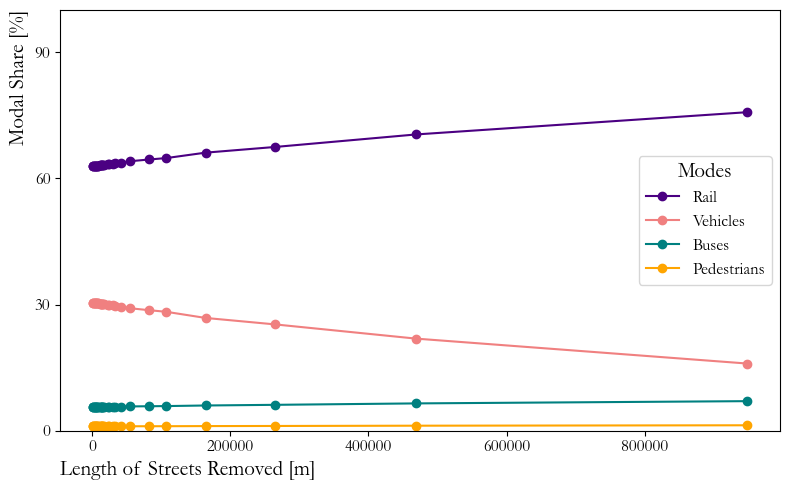

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

# plot the lines
models_length.plot.line(
    x = 'length_removed',
    y = ['rail', 'vehicle', 'bus', 'walk'],
    ax = ax,
    color = ['indigo', 'lightcoral', 'teal', 'orange'],
    marker = 'o'
)

plt.legend(
    loc = 'center right', 
    title = 'Modes',
    labels = ['Rail', 'Vehicles', 'Buses', 'Pedestrians'],
    fontsize = 12,
    title_fontsize = 15
)

ax.set_ylim([0, 1])
ax.set_yticks(np.arange(0,1,0.3))
ax.set_yticklabels(np.arange(0,100,30), fontsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)

ax.set_xlabel('Length of Streets Removed [m]', fontsize = 15, loc = 'left')
ax.set_ylabel('Modal Share [%]', fontsize = 15, loc = 'top')
# plt.title('Share of Transport Modes by Scenario')

plt.tight_layout()
plt.savefig('documents/img/modal_share_POI_length.png', bbox_inches = 'tight')

## Assign the Flows to the Network

In [17]:
# load networks
tokyo_drive_network = ox.load_graphml(os.path.join('data', 'tokyo', 'drive_network_updated.graphml'))

tokyo_multimodal_network = nx.read_graphml(os.path.join('data', 'tokyo', 'multimodal_network_updated_weight.graphml'))

In [18]:
for idx, row in models_df.iterrows():
    # extract data
    scenario = row['scenario']
    df = row['model'].copy()

    # log
    print(f'Processing {scenario}')

    # get path for driving
    df[f'driving_path_{scenario}_edit'] = df[f'driving_path_{scenario}'].apply(
        lambda x: [int(n) for n in x if not (isinstance(n, str) and ('zone' in n))]
    )
    
    # get flows for driving
    tokyo_drive_network = calculate_flow(
        tokyo_drive_network,
        df,
        flow = 'pred_vehicle',
        path = f'driving_path_{scenario}_edit',
        attr_name = f'flows_{scenario}'
    )

    for i, p in enumerate(modes['path']):
        # ignore vehicles
        if i == 0:
            continue

        # get path for public transport without the beginning and the finish
        df[f'{p}_edit'] = df[p].apply(
            lambda x: [n for n in x if not (isinstance(n, str) and ('zone' in n))]
        )

        # assign flows
        tokyo_multimodal_network = calculate_flow(
            tokyo_multimodal_network,
            df,
            flow = f"pred_{modes['modes'][i]}",
            path = f'{p}_edit',
            attr_name = f'flows_{scenario}'
        )


Processing orig
Processing removed_Ginza
Processing removed_Akihabara
Processing removed_Shinjuku
Processing removed_Chuo_dori
Processing removed_all
Processing removed_Ginza_nodes
Processing removed_Akihabara_nodes
Processing removed_Shinjuku_nodes
Processing removed_Chuo_dori_nodes
Processing removed_all_nodes
Processing 0
Processing 10
Processing 20
Processing 30
Processing 40
Processing 50
Processing 60
Processing 70
Processing 80
Processing 90
Processing 100
Processing 110
Processing 120
Processing 130
Processing 140
Processing 150
Processing 160
Processing 170
Processing 180
Processing 190
Processing 200
Processing 210
Processing 220
Processing 230
Processing 240
Processing 250
Processing 260
Processing 270
Processing 280
Processing 290
Processing 300


In [19]:
# save network as pickle

# Save the network object to a pickle file
with open('data/tokyo/drive_network_with_flow_multi.pkl', 'wb') as f:
    pickle.dump(tokyo_drive_network, f)

with open('data/tokyo/multimodal_network_with_flow_multi.pkl', 'wb') as f:
    pickle.dump(tokyo_multimodal_network, f)

In [32]:
sum([n[2]['flows_300'] for n in tokyo_multimodal_network.edges(data = True)])

7574177.0590038905

## Calculate Emissions

Using the flows, calculate the emissions

In [33]:
modes

{'modes': ['vehicle', 'bus', 'rail', 'walk'],
 'cost': ['drive_time', 'bus_time', 'rail_time', 'ped_time'],
 'path': ['drive_path', 'bus_path', 'rail_path', 'ped_path'],
 'observed_flow': ['vehicle', 'bus', 'rail', 'pedestrian']}

In [34]:
# define emissions for each mode (g/passenger km)
emissions_km = {
    'vehicle': 128,
    'bus': 71,
    'rail': 20
}

In [36]:
models_dict['scenario']

['orig',
 'removed_Ginza',
 'removed_Akihabara',
 'removed_Shinjuku',
 'removed_Chuo_dori',
 'removed_all',
 'removed_Ginza_nodes',
 'removed_Akihabara_nodes',
 'removed_Shinjuku_nodes',
 'removed_Chuo_dori_nodes',
 'removed_all_nodes',
 '0',
 '10',
 '20',
 '30',
 '40',
 '50',
 '60',
 '70',
 '80',
 '90',
 '100',
 '110',
 '120',
 '130',
 '140',
 '150',
 '160',
 '170',
 '180',
 '190',
 '200',
 '210',
 '220',
 '230',
 '240',
 '250',
 '260',
 '270',
 '280',
 '290',
 '300']

In [39]:
# initialise dictionary
emissions_dict = {
    'scenario': [],
    'vehicle': [],
    'bus': [],
    'rail': []
}

for m in models_dict['scenario']:
    print(f'Calculating emissions for {m}')
    em_temp = {}
    # calculate emissions for each mode
    em_temp['vehicle'] = sum([d['length'] * d[f'flows_{m}'] for u,v,k,d in tokyo_drive_network.edges(data = True, keys = True)])
    em_temp['bus'] = sum([d['weight_distance'] * d[f'flows_{m}'] for u,v,k,d in tokyo_multimodal_network.edges(data = True, keys = True) if ('layer' in d and d['layer'] == 'bus')])
    em_temp['rail'] = sum([d['weight_distance'] * d[f'flows_{m}'] for u,v,k,d in tokyo_multimodal_network.edges(data = True, keys = True) if ('layer' in d and d['layer'] == 'rail')])

    # add to dictionary
    emissions_dict['scenario'].append(m)
    for key in em_temp:
        emissions_dict[key].append(em_temp[key])


Calculating emissions for orig
Calculating emissions for removed_Ginza
Calculating emissions for removed_Akihabara
Calculating emissions for removed_Shinjuku
Calculating emissions for removed_Chuo_dori
Calculating emissions for removed_all
Calculating emissions for removed_Ginza_nodes
Calculating emissions for removed_Akihabara_nodes
Calculating emissions for removed_Shinjuku_nodes
Calculating emissions for removed_Chuo_dori_nodes
Calculating emissions for removed_all_nodes
Calculating emissions for 0
Calculating emissions for 10
Calculating emissions for 20
Calculating emissions for 30
Calculating emissions for 40
Calculating emissions for 50
Calculating emissions for 60
Calculating emissions for 70
Calculating emissions for 80
Calculating emissions for 90
Calculating emissions for 100
Calculating emissions for 110
Calculating emissions for 120
Calculating emissions for 130
Calculating emissions for 140
Calculating emissions for 150
Calculating emissions for 160
Calculating emissions 

In [49]:
# create dataframe
emissions_df = pd.DataFrame(emissions_dict)
for m in emissions_km:
    emissions_df[f'{m}_emissions'] = emissions_df[m] * emissions_km[m] / 1000

emissions_df['total_emissions'] = emissions_df[['vehicle_emissions', 'bus_emissions', 'rail_emissions']].sum(axis = 1)

In [21]:
emissions_df = pd.read_csv('data/tokyo/emissions_df.csv')

In [22]:
emissions_df.iloc[:11]

,scenario,vehicle,bus,rail,vehicle_emissions,bus_emissions,rail_emissions,total_emissions
0,orig,5.974602e+08,6.635629e+07,3.040111e+08,7.647490e+07,4.711296e+06,6.080221e+06,8.726642e+07
1,removed_Ginza,6.000303e+08,6.637804e+07,3.039998e+08,7.680388e+07,4.712841e+06,6.079995e+06,8.759671e+07
2,removed_Akihabara,5.974602e+08,6.635629e+07,3.040111e+08,7.647490e+07,4.711296e+06,6.080221e+06,8.726642e+07
3,removed_Shinjuku,5.974602e+08,6.635629e+07,3.040111e+08,7.647490e+07,4.711296e+06,6.080221e+06,8.726642e+07
4,removed_Chuo_dori,6.007299e+08,6.641431e+07,3.040082e+08,7.689343e+07,4.715416e+06,6.080164e+06,8.768901e+07
5,removed_all,6.000303e+08,6.637804e+07,3.039998e+08,7.680388e+07,4.712841e+06,6.079995e+06,8.759671e+07
6,removed_Ginza_nodes,5.998035e+08,6.633536e+07,3.038647e+08,7.677485e+07,4.709811e+06,6.077295e+06,8.756195e+07
7,removed_Akihabara_nodes,5.975819e+08,6.635937e+07,3.039981e+08,7.649048e+07,4.711515e+06,6.079962e+06,8.728196e+07
8,removed_Shinjuku_nodes,5.918224e+08,6.635276e+07,3.040142e+08,7.575327e+07,4.711046e+06,6.080284e+06,8.654460e+07
9,removed_Chuo_dori_nodes,5.971199e+08,6.690960e+07,3.033072e+08,7.643135e+07,4.750582e+06,6.066145e+06,8.724808e+07


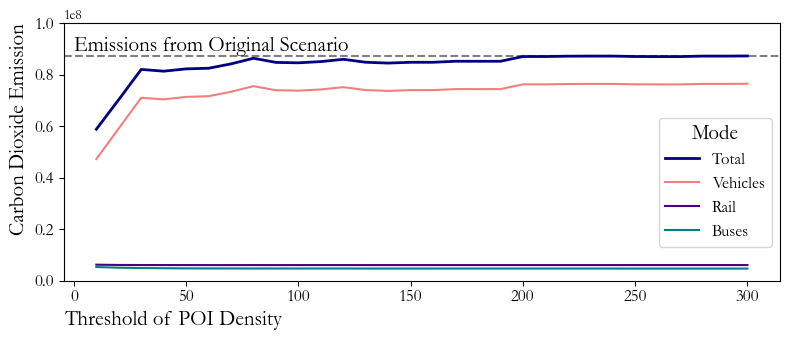

In [33]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Garamond', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']

fig, ax = plt.subplots(1, 1, figsize = (8,3.5))


plt.axhline(
    emissions_df.loc[emissions_df['scenario'] == 'orig', 'total_emissions'].iloc[0],
    color = 'gray',
    linestyle = '--'
)

emissions_df.iloc[12:].plot(
    x = 'scenario',
    y = 'total_emissions',
    ax = ax,
    color = 'navy',
    linewidth = 2,
    label = 'Total'
)

emissions_df.iloc[12:].plot(
    x = 'scenario',
    y = ['vehicle_emissions', 'rail_emissions', 'bus_emissions'],
    ax = ax,
    color = ['lightcoral', 'indigo', 'teal'],
    label = ['Vehicles', 'Rail', 'Buses']
)

ax.text(
    -1,
    emissions_df.loc[emissions_df['scenario'] == 'orig', 'total_emissions'].iloc[0],
    'Emissions from Original Scenario',
    va = 'bottom',
    fontsize = 15

)

ax.set_xticks(range(-1,30,5))
ax.set_xticklabels(range(0,320,50))

ax.set_ylim([0, 1e8])

ax.legend(title = 'Mode', fontsize = 12, title_fontsize = 15, loc = 'lower right', bbox_to_anchor = (1, 0.1))
ax.set_xlabel('Threshold of POI Density', fontsize = 15, loc = 'left')
ax.set_ylabel('Carbon Dioxide Emission', fontsize = 15, loc = 'top')
# ax.set_title('Change in Carbon Emissions by Scenario', fontsize = 20)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()

plt.savefig('documents/img/co2_poi.png')

In [24]:
emissions_length_df = emissions_df.iloc[12:].merge(
    lengths_df,
    left_on = 'scenario',
    right_on = 'poi_density',
    how = 'left'
)

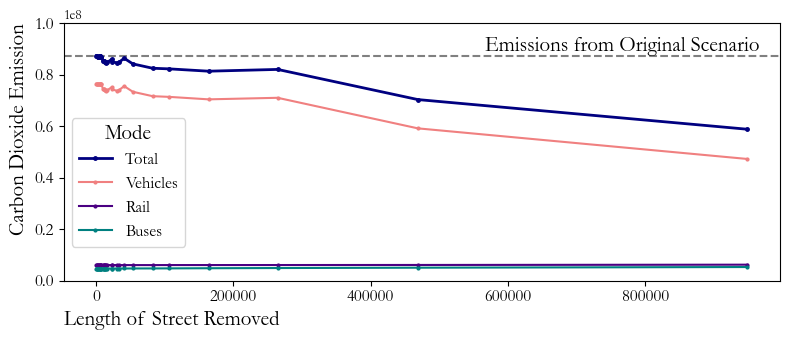

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (8,3.5))


plt.axhline(
    emissions_df.loc[emissions_df['scenario'] == 'orig', 'total_emissions'].iloc[0],
    color = 'gray',
    linestyle = '--'
)

emissions_length_df.plot(
    x = 'length_removed',
    y = 'total_emissions',
    ax = ax,
    color = 'navy',
    linewidth = 2,
    label = 'Total',
    marker = 'o',
    markersize = 2.5
)

emissions_length_df.plot(
    x = 'length_removed',
    y = ['vehicle_emissions', 'rail_emissions', 'bus_emissions'],
    ax = ax,
    color = ['lightcoral', 'indigo', 'teal'],
    label = ['Vehicles', 'Rail', 'Buses'],
    marker = 'o',
    markersize = 2
)

ax.text(
    ax.get_xlim()[1] - 30000,
    emissions_df.loc[emissions_df['scenario'] == 'orig', 'total_emissions'].iloc[0],
    'Emissions from Original Scenario',
    ha = 'right',
    va = 'bottom',
    fontsize = 15
)

ax.set_ylim([0,1e8])

ax.legend(title = 'Mode', fontsize = 12, title_fontsize = 15, loc = 'lower left', bbox_to_anchor = (0, 0.1))
ax.set_xlabel('Length of Street Removed', fontsize = 15, loc = 'left')
ax.set_ylabel('Carbon Dioxide Emission', fontsize = 15, loc = 'top')

# ax.set_title('Change in Carbon Emissions by Scenario', fontsize = 20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('documents/img/co2_poi_length.png')

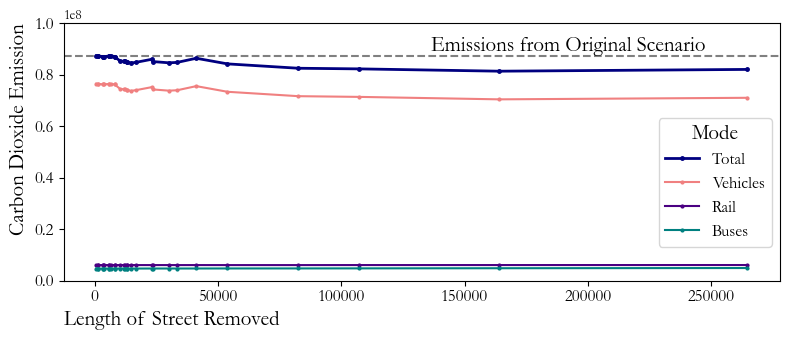

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (8,3.5))


plt.axhline(
    emissions_df.loc[emissions_df['scenario'] == 'orig', 'total_emissions'].iloc[0],
    color = 'gray',
    linestyle = '--'
)

emissions_length_df.iloc[2:].plot(
    x = 'length_removed',
    y = 'total_emissions',
    ax = ax,
    color = 'navy',
    linewidth = 2,
    label = 'Total',
    marker = 'o',
    markersize = 2.5
)

emissions_length_df.iloc[2:].plot(
    x = 'length_removed',
    y = ['vehicle_emissions', 'rail_emissions', 'bus_emissions'],
    ax = ax,
    color = ['lightcoral', 'indigo', 'teal'],
    label = ['Vehicles', 'Rail', 'Buses'],
    marker = 'o',
    markersize = 2
)

ax.text(
    ax.get_xlim()[1] - 30000,
    emissions_df.loc[emissions_df['scenario'] == 'orig', 'total_emissions'].iloc[0],
    'Emissions from Original Scenario',
    ha = 'right',
    va = 'bottom',
    fontsize = 15
)

ax.set_ylim([0,1e8])

ax.legend(title = 'Mode', fontsize = 12, title_fontsize = 15, loc = 'lower right', bbox_to_anchor = (1, 0.1))
ax.set_xlabel('Length of Street Removed', fontsize = 15, loc = 'left')
ax.set_ylabel('Carbon Dioxide Emission', fontsize = 15, loc = 'top')
# ax.set_title('Change in Carbon Emissions by Scenario', fontsize = 20)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('documents/img/co2_poi_length2.png')

In [27]:
# save emissions_df

emissions_df.to_csv('data/tokyo/emissions_df.csv', index = False)

In [28]:
emissions_df = pd.read_csv('data/tokyo/emissions_df.csv')

In [29]:
emissions_df

,scenario,vehicle,bus,rail,vehicle_emissions,bus_emissions,rail_emissions,total_emissions
0,orig,5.974602e+08,6.635629e+07,3.040111e+08,7.647490e+07,4.711296e+06,6.080221e+06,8.726642e+07
1,removed_Ginza,6.000303e+08,6.637804e+07,3.039998e+08,7.680388e+07,4.712841e+06,6.079995e+06,8.759671e+07
2,removed_Akihabara,5.974602e+08,6.635629e+07,3.040111e+08,7.647490e+07,4.711296e+06,6.080221e+06,8.726642e+07
3,removed_Shinjuku,5.974602e+08,6.635629e+07,3.040111e+08,7.647490e+07,4.711296e+06,6.080221e+06,8.726642e+07
4,removed_Chuo_dori,6.007299e+08,6.641431e+07,3.040082e+08,7.689343e+07,4.715416e+06,6.080164e+06,8.768901e+07
5,removed_all,6.000303e+08,6.637804e+07,3.039998e+08,7.680388e+07,4.712841e+06,6.079995e+06,8.759671e+07
6,removed_Ginza_nodes,5.998035e+08,6.633536e+07,3.038647e+08,7.677485e+07,4.709811e+06,6.077295e+06,8.756195e+07
7,removed_Akihabara_nodes,5.975819e+08,6.635937e+07,3.039981e+08,7.649048e+07,4.711515e+06,6.079962e+06,8.728196e+07
8,removed_Shinjuku_nodes,5.918224e+08,6.635276e+07,3.040142e+08,7.575327e+07,4.711046e+06,6.080284e+06,8.654460e+07
9,removed_Chuo_dori_nodes,5.971199e+08,6.690960e+07,3.033072e+08,7.643135e+07,4.750582e+06,6.066145e+06,8.724808e+07
